In [1]:
#if str(input(environment)) == 'venv':
#    %python pip install numpy
#    %python pip install matplotlib
#elif str(input(environment)) == 'conda':    
#    %conda install numpy 
#    %conda install matplotlib
#else:
#    install numpy
#    install matplotlib
#    break

In [1]:
%whos

Interactive namespace is empty.


In [13]:
import numpy as np
import pandas as pd
import zipfile as zf
import matplotlib.pylab as plt

binder=[]
if bool(input(binder))== True:
    df = pd.read_csv((zf.ZipFile("creditcard2.zip").open('creditcard2.csv')))[0:80_000].drop(columns='Unnamed: 0')
else:
    df  = pd.read_csv("C:/Users/Lenovo/OneDrive/Data Science project/Python.Data.Science/scikit-learn/scikit-metrics/creditcard.csv")[:80_000]

[] True


In [14]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values

In [4]:
y = df['Class'].values

In [5]:
y.sum()

196

In [6]:
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases={y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases=196'

# Grid Search Cross Validated Model

In [8]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(max_iter=1000)
f" Predicted cases of non-fraud: {mod.fit(X, y).predict(X).sum()}. We see that model mistakenly caught up false cases. Lets add weights."

' Predicted cases of non-fraud: 151.0. We see that model mistakenly caught up false cases. Lets add weights.'

In [9]:
mod = LogisticRegression(class_weight={0: 1, 1: 2}, max_iter=1000)
f" Predicted 'true' cases : {mod.fit(X, y).predict(X).sum()}."

" Predicted 'true' cases : 171.0."

In [10]:
lr = LogisticRegression()

In [11]:
??lr.fit

Signature: lr.fit(X, y, sample_weight=None)
Source:   
    def fit(self, X, y, sample_weight=None):
        """
        Fit the model according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like of shape (n_samples,)
            Target vector relative to X.

        sample_weight : array-like of shape (n_samples,) default=None
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

            .. versionadded:: 0.17
               *sample_weight* support to LogisticRegression.

        Returns
        -------
        self
            Fitted estimator.

        Notes
        -----
        The SAGA solver supports both float64 and float32 bit arrays.
        """
        sol

In [12]:
??lr.score

Signature: lr.score(X, y, sample_weight=None)
Source:   
    def score(self, X, y, sample_weight=None):
        """
        Return the mean accuracy on the given test data and labels.

        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test samples.

        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            True labels for `X`.

        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights.

        Returns
        -------
        score : float
            Mean accuracy of ``self.predict(X)`` wrt. `y`.
        """
        from .metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
File:      /srv/conda/envs/notebook/lib/python3.7/site-

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = LogisticRegression(max_iter=1000),
    param_grid = {'class_weight': [{0: 1, 1: v} for v in range(1, 4)]}, 
    cv = 4,
    n_jobs = -1)
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]})

In [14]:
from sklearn.metrics import precision_score, recall_score, make_scorer

recall_score(y, grid.predict(X))

0.5918367346938775

___________________________________
Level of truly predicted fraud cases on valide grid model.
____________________________________

In [15]:
_

0.5918367346938775

_______________________________
Time spent on cross validating model
_______________________________

In [16]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,10.818850,2.075004,0.027812,0.036767,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,11.549224,3.306873,0.073576,0.039109,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99025,0.99840,0.99960,0.99805,0.996575,0.003697,2
2,11.275580,2.445434,0.071463,0.037931,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


In [17]:
pd.DataFrame(grid.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [18]:
fit = grid.fit(X,y)

In [19]:
df = pd.DataFrame(grid.cv_results_)

In [20]:
_

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

# Plot 1

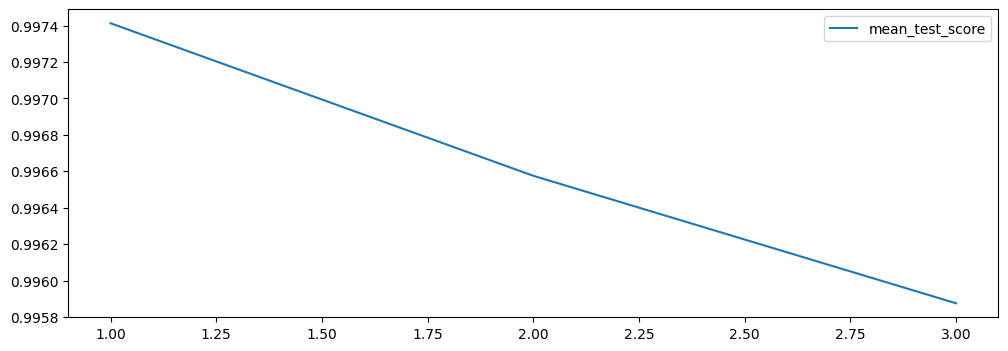

In [21]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_score']:
    plt.plot([_[1] for _ in df['param_class_weight']],
            df[score],
            label = score)
plt.legend();

_____________________________________

We have added precision.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score 

grid = GridSearchCV(estimator = LogisticRegression(max_iter=1000),
    param_grid = {'class_weight': [{0: 1, 1: v} for v in range(1, 4)]},
    scoring = {'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
    refit = 'precision',
    cv = 4,
    n_jobs = -1)
grid.fit(X, y)

GridSearchCV(cv=4, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}]},
             refit='precision',
             scoring={'precision': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [21]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,7.030212,1.286245,0.045707,0.036929,"{0: 1, 1: 1}","{'class_weight': {0: 1, 1: 1}}",0.99405,0.99835,0.99945,0.99780,0.997413,0.002030,1
1,7.115629,1.260300,0.011088,0.007168,"{0: 1, 1: 2}","{'class_weight': {0: 1, 1: 2}}",0.99025,0.99840,0.99960,0.99805,0.996575,0.003697,2
2,8.146681,1.766070,0.020695,0.028162,"{0: 1, 1: 3}","{'class_weight': {0: 1, 1: 3}}",0.98730,0.99845,0.99960,0.99815,0.995875,0.004980,3


In [23]:
pd.DataFrame(grid.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'params', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision',
       'split3_test_precision', 'mean_test_precision', 'std_test_precision',
       'rank_test_precision', 'split0_test_recall_score',
       'split1_test_recall_score', 'split2_test_recall_score',
       'split3_test_recall_score', 'mean_test_recall_score',
       'std_test_recall_score', 'rank_test_recall_score'],
      dtype='object')

## Model enhanced

### Refit precision

__________________________________

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

# for i in range(5,10):
#     while True:
#         try: grid = GridSearchCV(estimator = LogisticRegression(max_iter=1000),
#                 param_grid = {'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
#                 scoring = {'precision': make_scorer(precision_score), 'recall_score': make_scorer(recall_score)},
#                 refit = 'precision',
#                 return_train_score = True,
#                 cv = i,
#                 n_jobs = -1)
#              print("Number of cross-validations",i, grid.fit(X, y))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

grid = GridSearchCV(estimator = LogisticRegression(max_iter=1000),
    param_grid = {'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring = {'precision': make_scorer(precision_score), 
               'recall_score': make_scorer(recall_score)},
    refit = 'precision',
    return_train_score = True,
    cv = 10,
    n_jobs = -1)
grid.fit(X, y)

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot 2

In [ ]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score','mean_test_precision']:
    plt.plot([_[1] for _ in df['param_class_weight']],
            df[score],
            label = score)
plt.legend();

In [ ]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall_score','mean_train_precision']:
    plt.plot(x = [_[1] for _ in df['param_class_weight']],
            y = df[score.replace('test','train')],
            label = score)
plt.legend();

# Definition of precision recalling function 

In [ ]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

In [ ]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

make_scorer(min_recall_precision, greater_is_better=False)

In [ ]:
# ?make_scorer

In [ ]:
# s = make_scorer(min_recall_precision)
# ??s

____________________

### Choose minimal recall rate and precision level

In [ ]:
from sklearn.metrics import precision_score, recall_score

def min_recall_precision(y_true, y_pred):
    recall= recall_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred)
    return mon(recall, precision)

grid = GridSearchCV(estimator = LogisticRegression(max_iter=1000),
    param_grid = {'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring = {'precision': make_scorer(precision_score), 
               'recall_score': make_scorer(recall_score),
              'min_both': make_scorer(min_recall_precision)},               
    refit = 'min_both',
    return_train_score = True,
    cv = 10,
    n_jobs = -1)
grid.fit(X, y);

In [ ]:
s = make_scorer(min_recall_precision)
??s

# Plot 3

In [ ]:
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall_score','mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df['param_class_weight']],
            y = df[score],
            label = score)
plt.legend();

In [ ]:
from sklearn.metrics import precision_score, recall_score, make_scorer

def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 20, 30)]},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score),
             'min_both': min_recall_precision},
    refit='min_both',
    return_train_score=True,
    cv=10,
    n_jobs=-1
)
if str(input(weight))== 'added':
grid.fit(X, y);
else:
grid.fit(X, y, sample_weight = np.log(1+ df['Amount']));

Here's a summary for the test metrics.

# Plot 4

In [ ]:
plt.subplot(1,2,1)
plt.figure(figsize=(12,4))
df = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall','mean_test_precision', 'mean_test_min_both']:
    plt.plot([_[1] for _ in df['param_class_weight']],
            y = df[score],
            label = score)
plt.legend();

And here's the train metrics.

In [ ]:
plt.subplot(1,2,2)
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall', 'mean_train_precision', 'mean_test_min_both']:
    plt.scatter(x=[_[1] for _ in df_results['param_class_weight']], 
                y=df_results[score.replace('test', 'train')], 
                label=score)
plt.legend();

# Using Outlier Detection Models

In [ ]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X); print("Prediction: ", mod.predict(X), ".")
#how frequent predicted outliers
Counter(mod.predict(X))

np.where(mod.predict(X) == -1, 1, 0)

And now in a gridsearch.

In [ ]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == -1, 1, 0))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == -1, 1, 0))

grid = GridSearchCV(
    estimator=IsolationForest(),
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)},
    scoring={'precision': outlier_precision, 
             'recall': outlier_recall},
    refit='precision',
    cv=5,
    n_jobs=-1
)
grid.fit(X, y);

plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'], 
             df_results[score], 
             label=score)
plt.legend();

In [ ]:
df = pd.DataFrame(grid.cv_results_)
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_recall'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_precision']);

In [ ]:
def min_pre_rec(y, y_true):
    return min(recall_score(y, y_true), precision_score(y, y_true))

In [ ]:
def outlier_precision(mod, X, y):
    preds = mod.predict(X)
    return precision_score(y, np.where(preds == 1, 0, 1))

def outlier_recall(mod, X, y):
    preds = mod.predict(X)
    return recall_score(y, np.where(preds == 1, 0, 1))

In [ ]:
grid = GridSearchCV(
    estimator=LogisticRegression(class_weight=10),
    param_grid={'class_weight': [{0: 1, 1: v} for v in np.linspace(1, 40, t5)]},
    scoring={'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'min_pre_rec': make_scorer(min_pre_rec)},
    refit='precision',
    cv = 10,
    n_jobs=-1
)
grid.fit(X, y)

# Plot 5

In [ ]:
df = pd.DataFrame(grid.cv_results_)
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_recall'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_precision'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_min_pre_rec']);

In [ ]:
_ = make_scorer(recall_score)

In [ ]:
import numpy as np 

np.eye(4)